In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

%matplotlib inline
print("✓ Все библиотеки успешно импортированы")

✓ Все библиотеки успешно импортированы


In [7]:
def load_or_create_gray(path, size=(256,256)):
    if os.path.exists(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            return img
    img = np.tile(np.linspace(0,255,size[0],dtype=np.uint8), (size[1],1))
    return img

def gamma_correction(image, gamma):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(256)]).astype('uint8')
    return cv2.LUT(image, table)

def mse(a, b):
    return np.mean((a.astype('float64') - b.astype('float64')) ** 2)

def histogram_match(source, template):
    src = source.ravel()
    tmpl = template.ravel()
    s_values, bin_idx, s_counts = np.unique(src, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(tmpl, return_counts=True)
    s_quantiles = np.cumsum(s_counts).astype(np.float64) / src.size
    t_quantiles = np.cumsum(t_counts).astype(np.float64) / tmpl.size
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    return interp_t_values[bin_idx].reshape(source.shape).astype('uint8')

# Статистическая цветокоррекция
def statistical_color_correction(source, target):
    """
    Статистическая цветокоррекция источника к целевому изображению
    source: исходное изображение для коррекции
    target: целевое изображение, к статистике которого приводим source
    """
    mean_source = np.mean(source)
    std_source = np.std(source)
    
    mean_target = np.mean(target)
    std_target = np.std(target)
    if std_source == 0:
        std_source = 1
    corrected = ((source - mean_source) * (std_target / std_source)) + mean_target
    corrected = np.clip(corrected, 0, 255)
    
    return corrected.astype('uint8')

print("✓ Функции загружены")

✓ Функции загружены


=== ЗАДАНИЕ 1: Загрузка изображения ===


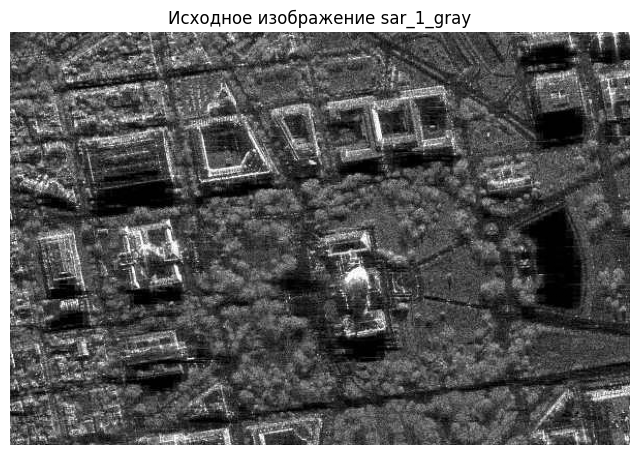

Shape: (400, 600)
Min intensity: 0 Max intensity: 255
Mean intensity: 74.94157083333333


In [9]:
print("=== ЗАДАНИЕ 1: Загрузка изображения ===")
img_path = r'C:\Users\engfile\image_processing\dz1\sar_1_gray.jpg'
img = load_or_create_gray(img_path)

plt.figure(figsize=(8, 6))
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение sar_1_gray')
plt.axis('off')
plt.show()

print('Shape:', img.shape)
print('Min intensity:', img.min(), 'Max intensity:', img.max())
print('Mean intensity:', img.mean())


=== ЗАДАНИЕ 2: Гистограмма изображения ===


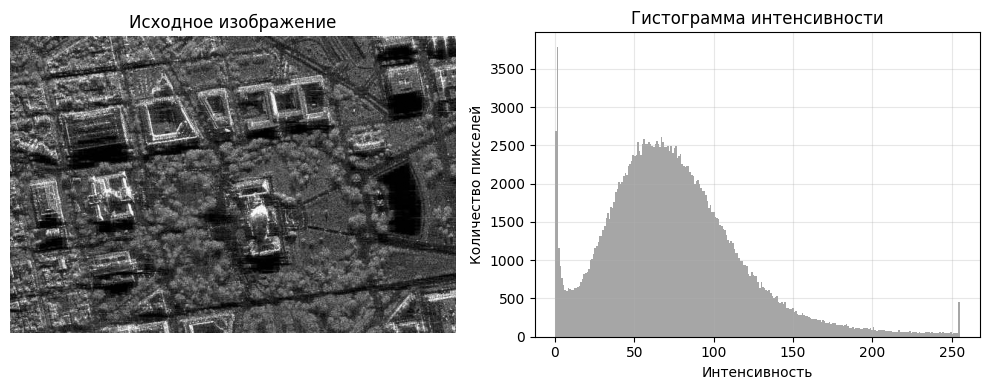

In [15]:
print("\n=== ЗАДАНИЕ 2: Гистограмма изображения ===")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(img.ravel(), bins=256, range=(0,255), color='gray', alpha=0.7)
plt.title('Гистограмма интенсивности')
plt.xlabel('Интенсивность')
plt.ylabel('Количество пикселей')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== ЗАДАНИЕ 3: Гамма-коррекция ===


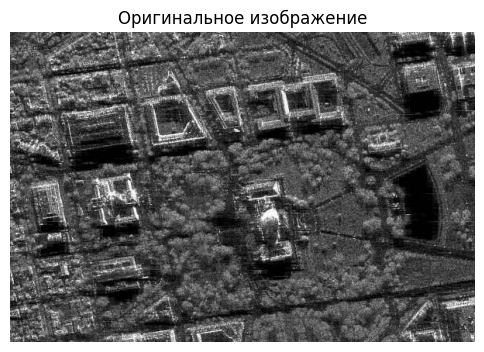

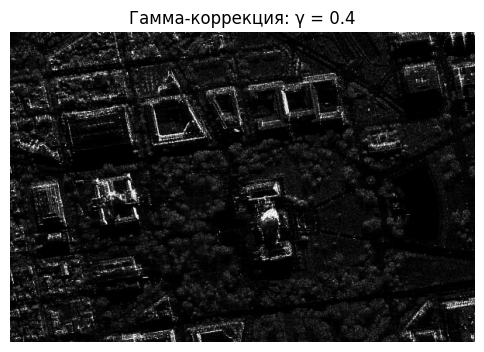

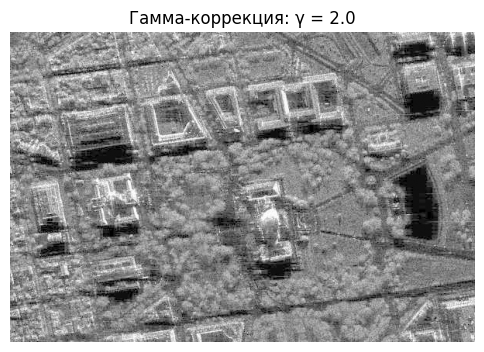

Статистика гамма-коррекции:
Оригинал: mean=74.94, std=43.66
Gamma 0.4: mean=19.56, std=31.16
Gamma 2.0: mean=130.56, std=43.86


In [16]:
print("\n=== ЗАДАНИЕ 3: Гамма-коррекция ===")

# Оригинал
plt.figure(figsize=(6, 5))
plt.imshow(img, cmap='gray')
plt.title('Оригинальное изображение')
plt.axis('off')
plt.show()

# Gamma 0.4
gamma_04 = gamma_correction(img, 0.4)
plt.figure(figsize=(6, 5))
plt.imshow(gamma_04, cmap='gray')
plt.title('Гамма-коррекция: γ = 0.4')
plt.axis('off')
plt.show()

# Gamma 2.0
gamma_20 = gamma_correction(img, 2.0)
plt.figure(figsize=(6, 5))
plt.imshow(gamma_20, cmap='gray')
plt.title('Гамма-коррекция: γ = 2.0')
plt.axis('off')
plt.show()

print("Статистика гамма-коррекции:")
print(f"Оригинал: mean={img.mean():.2f}, std={img.std():.2f}")
print(f"Gamma 0.4: mean={gamma_04.mean():.2f}, std={gamma_04.std():.2f}")
print(f"Gamma 2.0: mean={gamma_20.mean():.2f}, std={gamma_20.std():.2f}")

In [17]:
print("\n=== ЗАДАНИЕ 4: Сравнение метриками MSE и SSIM ===")

img_g04 = gamma_correction(img, 0.4)
img_g20 = gamma_correction(img, 2.0)

print("Сравнение с исходным изображением:")
print("-" * 40)

for name, other in [('gamma_0.4', img_g04), ('gamma_2.0', img_g20)]:
    m = mse(img, other)
    s = ssim(img, other, data_range=255)
    print(f'Original vs {name}:')
    print(f'  MSE = {m:.2f}')
    print(f'  SSIM = {s:.4f}')
    print()


=== ЗАДАНИЕ 4: Сравнение метриками MSE и SSIM ===
Сравнение с исходным изображением:
----------------------------------------
Original vs gamma_0.4:
  MSE = 3556.52
  SSIM = 0.3285

Original vs gamma_2.0:
  MSE = 3250.43
  SSIM = 0.7875




=== ЗАДАНИЕ 5: Статистическая цветокоррекция (ИСПРАВЛЕННАЯ) ===


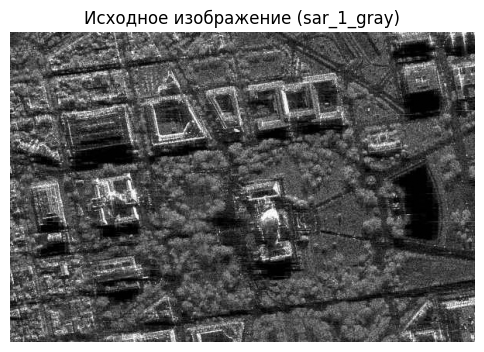

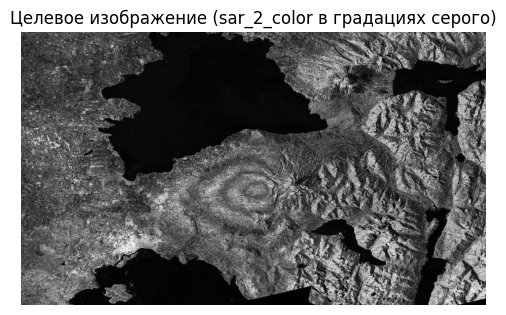

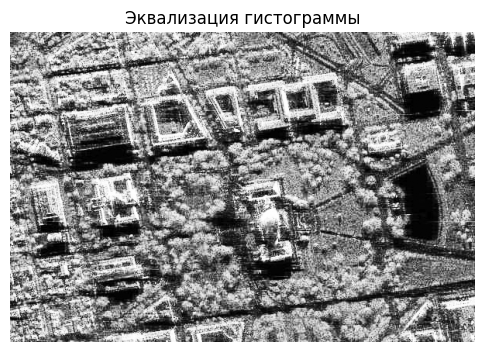

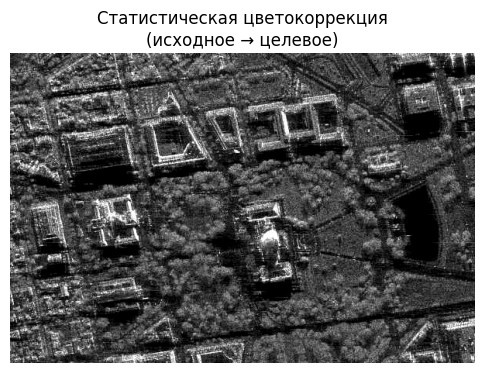

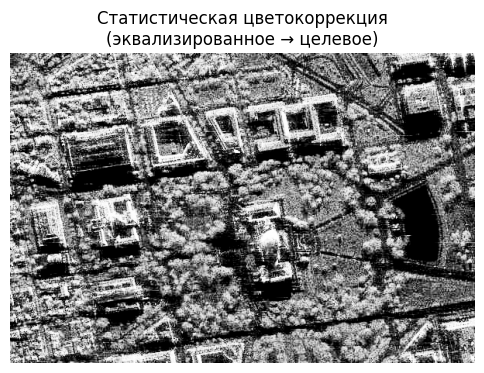

Статистика интенсивностей:
Исходное:          mean=74.94, std=43.66
Целевое (img2):    mean=67.40, std=52.03
Эквализированное:  mean=127.03, std=74.27
Скорректированное: mean=67.93, std=49.90
Скорректир. экв.:  mean=68.43, std=49.75

Сравнение с целевым изображением:


ValueError: operands could not be broadcast together with shapes (572,974) (400,600) 

In [ ]:
print("\n=== ЗАДАНИЕ 5: Статистическая цветокоррекция (ИСПРАВЛЕННАЯ) ===")

# Загружаем второе изображение для цветокоррекции
img2_path = r'C:\Users\engfile\image_processing\dz1\sar_2_color.jpg'
img2 = load_or_create_gray(img2_path)

# Приводим изображения к одному размеру (берем размер первого изображения)
target_size = (img.shape[1], img.shape[0])  # (width, height)
img2_resized = cv2.resize(img2, target_size)

print(f"Размеры изображений:")
print(f"Исходное: {img.shape}")
print(f"Целевое: {img2.shape} -> после изменения размера: {img2_resized.shape}")

# 1. Исходное изображение
plt.figure(figsize=(6, 5))
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение (sar_1_gray)')
plt.axis('off')
plt.show()

# 2. Второе изображение (целевое) - измененного размера
plt.figure(figsize=(6, 5))
plt.imshow(img2_resized, cmap='gray')
plt.title('Целевое изображение (sar_2_color в градациях серого)\nизмененного размера')
plt.axis('off')
plt.show()

# 3. Эквализация гистограммы
eq_gray = cv2.equalizeHist(img)
plt.figure(figsize=(6, 5))
plt.imshow(eq_gray, cmap='gray')
plt.title('Эквализация гистограммы')
plt.axis('off')
plt.show()

# 4. Статистическая цветокоррекция исходного к целевому
stat_corrected = statistical_color_correction(img, img2_resized)
plt.figure(figsize=(6, 5))
plt.imshow(stat_corrected, cmap='gray')
plt.title('Статистическая цветокоррекция\n(исходное → целевое)')
plt.axis('off')
plt.show()

# 5. Статистическая цветокоррекция эквализированного к целевому
stat_corrected_eq = statistical_color_correction(eq_gray, img2_resized)
plt.figure(figsize=(6, 5))
plt.imshow(stat_corrected_eq, cmap='gray')
plt.title('Статистическая цветокоррекция\n(эквализированное → целевое)')
plt.axis('off')
plt.show()

print('Статистика интенсивностей:')
print(f'Исходное:          mean={img.mean():.2f}, std={img.std():.2f}')
print(f'Целевое (img2):    mean={img2_resized.mean():.2f}, std={img2_resized.std():.2f}')
print(f'Эквализированное:  mean={eq_gray.mean():.2f}, std={eq_gray.std():.2f}')
print(f'Скорректированное: mean={stat_corrected.mean():.2f}, std={stat_corrected.std():.2f}')
print(f'Скорректир. экв.:  mean={stat_corrected_eq.mean():.2f}, std={stat_corrected_eq.std():.2f}')

# Сравнение метриками (теперь размеры совпадают)
print("\nСравнение с целевым изображением:")
mse_stat = mse(img2_resized, stat_corrected)
ssim_stat = ssim(img2_resized, stat_corrected, data_range=255)

mse_stat_eq = mse(img2_resized, stat_corrected_eq)
ssim_stat_eq = ssim(img2_resized, stat_corrected_eq, data_range=255)

print(f'Целевое vs Скорректированное:')
print(f'  MSE = {mse_stat:.2f}, SSIM = {ssim_stat:.4f}')
print(f'Целевое vs Скорректир. экв.:')
print(f'  MSE = {mse_stat_eq:.2f}, SSIM = {ssim_stat_eq:.4f}')


=== ЗАДАНИЕ 6: Пороговая фильтрация ===
Простые пороги:


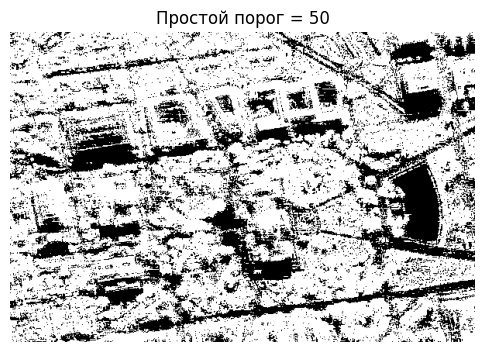

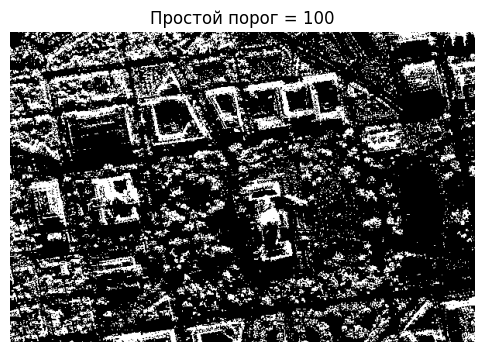

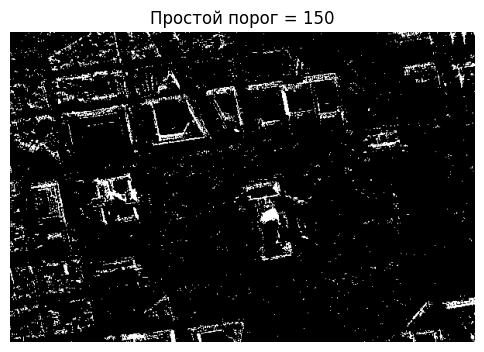

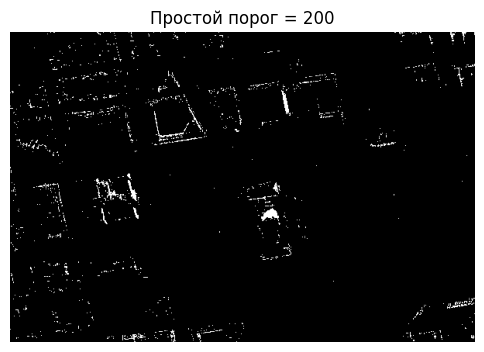


Адаптивная пороговая фильтрация:


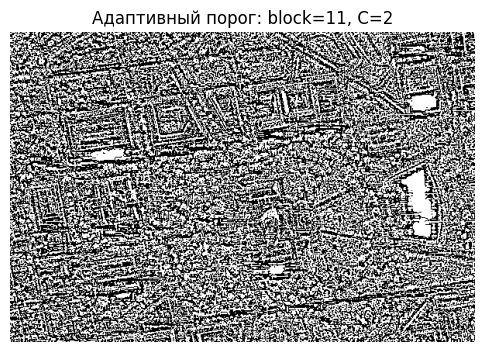

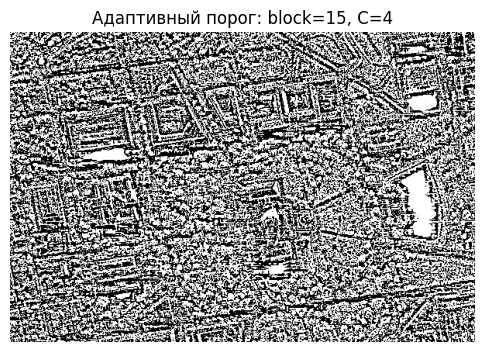

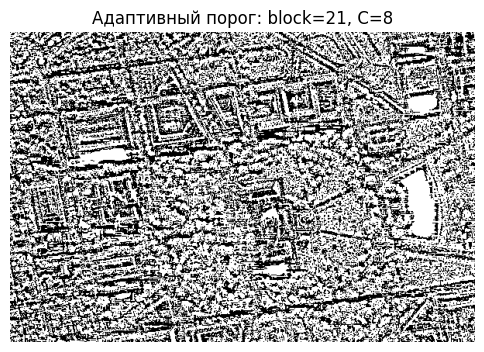


Метод Отсу:


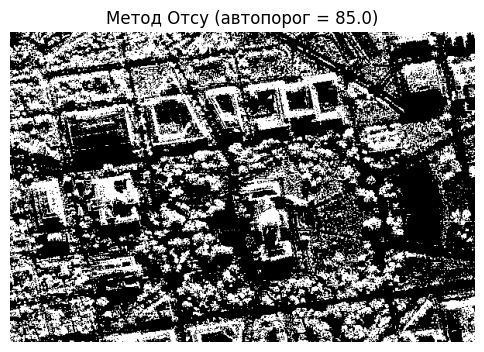

Автоматически найденный порог Отсу: 85.00


In [19]:
print("\n=== ЗАДАНИЕ 6: Пороговая фильтрация ===")

# Простые пороги
print("Простые пороги:")
thresholds = [50, 100, 150, 200]

for threshold in thresholds:
    _, th = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    plt.figure(figsize=(6, 5))
    plt.imshow(th, cmap='gray')
    plt.title(f'Простой порог = {threshold}')
    plt.axis('off')
    plt.show()

# Адаптивная фильтрация
print("\nАдаптивная пороговая фильтрация:")
adaptive_params = [(11, 2), (15, 4), (21, 8)]

for block_size, c in adaptive_params:
    th_adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, block_size, c)
    plt.figure(figsize=(6, 5))
    plt.imshow(th_adaptive, cmap='gray')
    plt.title(f'Адаптивный порог: block={block_size}, C={c}')
    plt.axis('off')
    plt.show()

# Метод Отсу
print("\nМетод Отсу:")
_, th_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
otsu_threshold = _

plt.figure(figsize=(6, 5))
plt.imshow(th_otsu, cmap='gray')
plt.title(f'Метод Отсу (автопорог = {otsu_threshold:.1f})')
plt.axis('off')
plt.show()

print(f'Автоматически найденный порог Отсу: {otsu_threshold:.2f}')